In [4427]:
import sympy as sp
import numpy as np
import numba as nb
import matplotlib.pyplot as plt

Гамильтониан для релятивистской частицы в скалярном потенциальном поле
$$H = \sqrt{\vec{P}^T\vec{P}c^2+m^2c^4} + U(\vec{r})$$

$$\gamma = \sqrt{1-\frac{v^2}{c^2}}$$

$$U(\vec{r}) = -\frac{gMm}{\sqrt{r^2_x+r^2_y}}$$

In [4428]:
P = sp.symbols('P_:{}'.format(2))
r = sp.symbols('r_:{}'.format(2))
v = sp.symbols('v_:{}'.format(2))

g, gamma, m,c, M = sp.symbols('g gamma m c M')

In [4429]:
PP = sp.Matrix([P[0], P[1]])
rr = sp.Matrix([r[0], r[1]])
vv = sp.Matrix([v[0], v[1]])

In [4430]:
H = sp.sqrt(PP.dot(PP)*c**2 + m**2*c**4) - g*m*M/sp.sqrt(rr.dot(rr))
H

-M*g*m/sqrt(r_0**2 + r_1**2) + sqrt(c**4*m**2 + c**2*(P_0**2 + P_1**2))

In [4431]:
p_dot_0 = -sp.diff(H, r[0])
[p_dot_0]

[-M*g*m*r_0/(r_0**2 + r_1**2)**(3/2)]

In [4432]:
p_dot_1 = -sp.diff(H, r[1])
[p_dot_1]

[-M*g*m*r_1/(r_0**2 + r_1**2)**(3/2)]

In [4433]:
r_dot_0 = sp.diff(H, P[0])
[r_dot_0]

[P_0*c**2/sqrt(c**4*m**2 + c**2*(P_0**2 + P_1**2))]

In [4434]:
r_dot_1 = sp.diff(H, P[1])
[r_dot_1]

[P_1*c**2/sqrt(c**4*m**2 + c**2*(P_0**2 + P_1**2))]

In [4435]:
H_no_rel = PP.dot(PP)/(2*m) - g*m*M/sp.sqrt(rr.dot(rr))
H_no_rel

-M*g*m/sqrt(r_0**2 + r_1**2) + (P_0**2 + P_1**2)/(2*m)

In [4436]:
r_n0_rel_dot_0 = sp.diff(H_no_rel, P[0])
[r_n0_rel_dot_0]

[P_0/m]

In [4437]:
r_n0_rel_dot_1 = sp.diff(H_no_rel, P[1])
[r_n0_rel_dot_1]

[P_1/m]

In [4438]:
@nb.njit
def right_part(arg, g, m, MM, c):

    r_0, r_1 = arg[2:]
    
    P_0, P_1 = arg[:2]

    rp = np.array([-g*MM*m*r_0/(r_0**2 + r_1**2)**(3/2),
                   -g*MM*m*r_1/(r_0**2 + r_1**2)**(3/2),
                   P_0*c**2/np.sqrt(c**4*m**2 + c**2*(P_0**2 + P_1**2)),
                   P_1*c**2/np.sqrt(c**4*m**2 + c**2*(P_0**2 + P_1**2))], dtype=np.float64)

    
    return rp

In [4439]:
@nb.njit
def solver(N, dt, P0, Q0, g, m, MM, c):
    
    left_part = np.zeros((4,N), dtype=np.float64)
    left_part[0,0], left_part[1,0] = P0
    left_part[2,0], left_part[3,0] = Q0
    
    for i in range(N-1):
        
        k1 = np.zeros((4), dtype=np.float64)
        k2 = np.zeros((4), dtype=np.float64)
        k3 = np.zeros((4), dtype=np.float64)
        k4 = np.zeros((4), dtype=np.float64)
        
        k1 = right_part(left_part[:,i], g, m, MM, c)
        k2 = right_part(left_part[:,i]+k1*dt/2, g, m, MM, c)
        k3 = right_part(left_part[:,i]+k2*dt/2, g, m, MM, c)
        k4 = right_part(left_part[:,i]+k3*dt, g, m, MM, c)
        
        left_part[:,i+1] = left_part[:,i] + dt*(k1[:] + 2*k2[:] + 2*k3[:] + k4[:])/6
    
    return left_part

In [4440]:
@nb.njit
def right_part_no_rel(arg, g, m, MM, c):
        
    r_0, r_1 = arg[2:]
    
    P_0, P_1 = arg[:2]
    
    rp = np.array([-g*MM*m*r_0/(r_0**2 + r_1**2)**(3/2),
                   -g*MM*m*r_1/(r_0**2 + r_1**2)**(3/2),
                   P_0/m ,
                   P_1/m ], dtype=np.float64)
    
    return rp

In [4441]:
@nb.njit
def solver_no_rel(N, dt, P0, Q0, g, m, MM, c):
    
    left_part = np.zeros((4,N), dtype=np.float64)
    left_part[0,0], left_part[1,0] = P0
    left_part[2,0], left_part[3,0] = Q0
    
    for i in range(N-1):
        
        k1 = np.zeros((4), dtype=np.float64)
        k2 = np.zeros((4), dtype=np.float64)
        k3 = np.zeros((4), dtype=np.float64)
        k4 = np.zeros((4), dtype=np.float64)
        
        k1 = right_part_no_rel(left_part[:,i], g, m, MM, c)
        k2 = right_part_no_rel(left_part[:,i]+k1*dt/2, g, m, MM, c)
        k3 = right_part_no_rel(left_part[:,i]+k2*dt/2, g, m, MM, c)
        k4 = right_part_no_rel(left_part[:,i]+k3*dt, g, m, MM, c)
        
        left_part[:,i+1] = left_part[:,i] + dt*(k1[:] + 2*k2[:] + 2*k3[:] + k4[:])/6
    
    return left_part

In [4442]:
N = 100000

h = 1e-2

g  = 1.0
MM = 1.0
c  = 1.0
m  = 0.01


r0   = 25    
vp   = 0.1

P_0 = np.array([m*vp, 0.0], dtype=np.float64)
Q_0 = np.array([0.0, r0], dtype=np.float64)


PQ_equal = solver(N, h, P_0, Q_0, g, m, MM, c)

PQ_equal_no_rel = solver_no_rel(N, h, P_0, Q_0, g, m, MM, c)

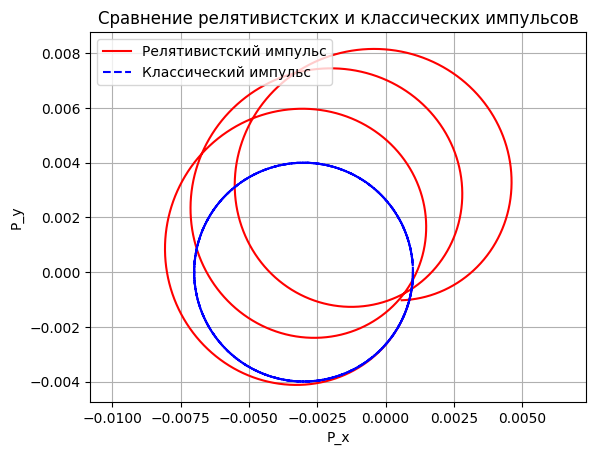

In [4443]:
plt.plot(PQ_equal[0],PQ_equal[1],'r-', label='Релятивистский импульс')
plt.plot(PQ_equal_no_rel[0],PQ_equal_no_rel[1], 'b--', label='Классический импульс')
plt.xlabel('P_x') 
plt.ylabel('P_y')
plt.title('Сравнение релятивистских и классических импульсов')
plt.axis('equal')
plt.legend()
plt.grid(True)
plt.show()

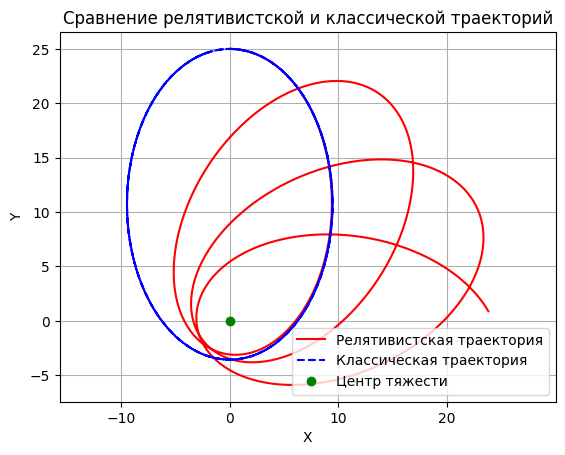

In [4444]:
plt.plot(PQ_equal[2],PQ_equal[3],'r-', label='Релятивистская траектория')
plt.plot(PQ_equal_no_rel[2],PQ_equal_no_rel[3], 'b--', label='Классическая траектория')
plt.plot(0.0, 0.0, 'go', label='Центр тяжести')
plt.xlabel('X') 
plt.ylabel('Y')
plt.title('Сравнение релятивистской и классической траекторий')
plt.axis('equal')
plt.legend()
plt.grid(True)
plt.show()